In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
import mlflow
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sqlalchemy import create_engine
import psycopg2
import io


In [2]:
dbname = 'base_app'
user = 'postgres'
password = 'cost#123$'
host = 'localhost'
port = '5432'

conn = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

In [3]:
query = "SELECT id, excel_file FROM prediction_request WHERE status = 'APPROVED'"

In [4]:
idsWithPredictions = {}
with conn.cursor() as cur:
    cur.execute(query)
    data = b''
    while True:
        row = cur.fetchone()
        if row is None:
            break
        idsWithPredictions[row[0]] = bytearray(row[1])
cur.close()

In [5]:
def custom_date_parser(date_str):
    return pd.to_datetime(date_str, format='%Y-%m-%d')

In [6]:
def splitToTrainAndTest(data, period_from, period_to) :
    
    cutoff_date_start = period_from
    train = data[data['Date'] < cutoff_date_start]
    
    cutoff_date_end = period_to
    test = data[(data['Date'] >= cutoff_date_start) & (data['Date'] <= cutoff_date_end)]
    
    data_attr_train = train.drop(columns=['Value'])
    data_target_train = train.get("Value")
    data_attr_test = test.drop(columns=['Value'])
    data_target_test = test.get("Value")
    return data_attr_train, data_attr_test, data_target_train, data_target_test

In [7]:
def concatenate_columns(row):
    return f"{int(row['year'])}-{int(row['month'])}-{int(row['day'])}"

In [8]:
def plotColumnsWithDetails(attributes, actual_target, predicted_target) :
    dataframeRes = attributes.assign(Date=attributes.apply(concatenate_columns, axis = 1))
    dataframeRes['predicted_target'] = predicted_target
    dataframeRes['actual_target'] = actual_target
    print(dataframeRes)
    fig, ax = plt.subplots(figsize=(30, 15))

    ax.plot(pd.to_datetime(dataframeRes['Date']), dataframeRes['predicted_target'], marker='o', linestyle='-', color='red')
    ax.plot(pd.to_datetime(dataframeRes['Date']), dataframeRes['actual_target'], marker='o', linestyle='-', color='blue')

    print('RMSE: ', round(
        mean_squared_error(
            y_true=dataframeRes['actual_target'],
            y_pred=dataframeRes['predicted_target']
        ),3
    ))
    print('MAE: ', round(
        mean_absolute_error(
            y_true=dataframeRes['actual_target'],
            y_pred=dataframeRes['predicted_target']
        ),3
    ))
    print('MAPE: ', round(
        mean_absolute_percentage_error(
            y_true = dataframeRes['actual_target'],
            y_pred =dataframeRes['predicted_target']
        ),3\
    ))
    plt.grid(True)
    plt.show()

In [9]:
warnings.filterwarnings('ignore')

In [10]:
def add_lagged_features(data, lags):
    for lag in lags:
        data[f'Value_lag_{lag}'] = data['Value'].shift(lag)
    return data

def add_differenced_features(data, diffs):
    for differ in diffs:
        data[f'Value_differ_{differ}'] = data['Value'].diff(differ)
    return data

In [11]:
def add_date_features(data):
    data['year'] = data['Date'].dt.year
    data['weekofyear'] = data['Date'].dt.isocalendar().week
    # data['dayofyear'] = data['Date'].dt.dayofyear
    data['quarter'] = data['Date'].dt.quarter
    data['month'] = data['Date'].dt.month
    data['dayofweek'] = data['Date'].dt.dayofweek
    data['day'] = data['Date'].dt.day
    data = data.drop(columns=['Date'])
    return data


In [12]:
def read_write_csv(fileContent, id, custom_date_parser):
    df = pd.read_csv(io.BytesIO(fileContent))
    df.to_csv(f"trainable{id}.csv", index=False)
    data = pd.read_csv(f"trainable{id}.csv", parse_dates=['Date'], date_parser=custom_date_parser)
    return data


In [13]:
def generate_next_90_days_dataframe(dataframe, date_column_name):
    last_date = dataframe[date_column_name].max()
    next_90_days_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=6*30, freq='D')
    df_next_90_days = pd.DataFrame({'Date': next_90_days_dates})
    df_next_90_days['Date'] = pd.to_datetime(df_next_90_days['Date'], format='%Y-%m-%d')
    df_next_90_days['Value'] = None
    df_next_90_days['Value'] =  df_next_90_days['Value'].fillna(0)
    print(df_next_90_days['Value'])
    return df_next_90_days


0      0
1      0
2      0
3      0
4      0
      ..
175    0
176    0
177    0
178    0
179    0
Name: Value, Length: 180, dtype: int64
        Date      Value
0 2013-01-01  10.000000
1 2013-01-02   7.400000
2 2013-01-03   7.166667
3 2013-01-04   8.666667
4 2013-01-05   6.000000
Dataframe next 90 days
        Date  Value
0 2017-01-02      0
1 2017-01-03      0
2 2017-01-04      0
3 2017-01-05      0
4 2017-01-06      0
Last date from file:
2017-01-01 00:00:00
{'max_depth': 4, 'n_estimators': 100}
      year  weekofyear  quarter  month  dayofweek  day       Date  \
0     2013           1        1      1          1    1   2013-1-1   
1     2013           1        1      1          2    2   2013-1-2   
2     2013           1        1      1          3    3   2013-1-3   
3     2013           1        1      1          4    4   2013-1-4   
4     2013           1        1      1          5    5   2013-1-5   
...    ...         ...      ...    ...        ...  ...        ...   
1242  2016   

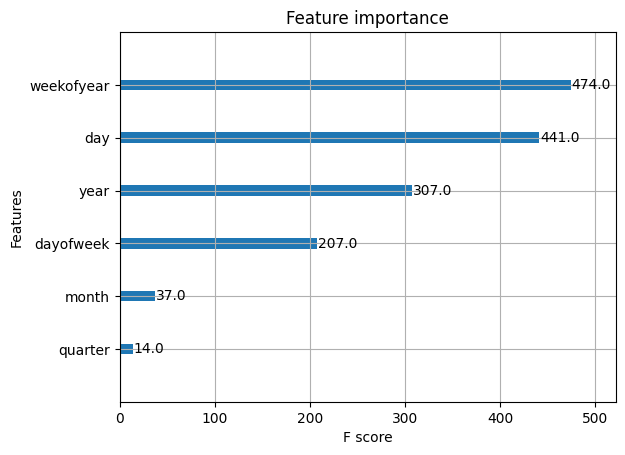

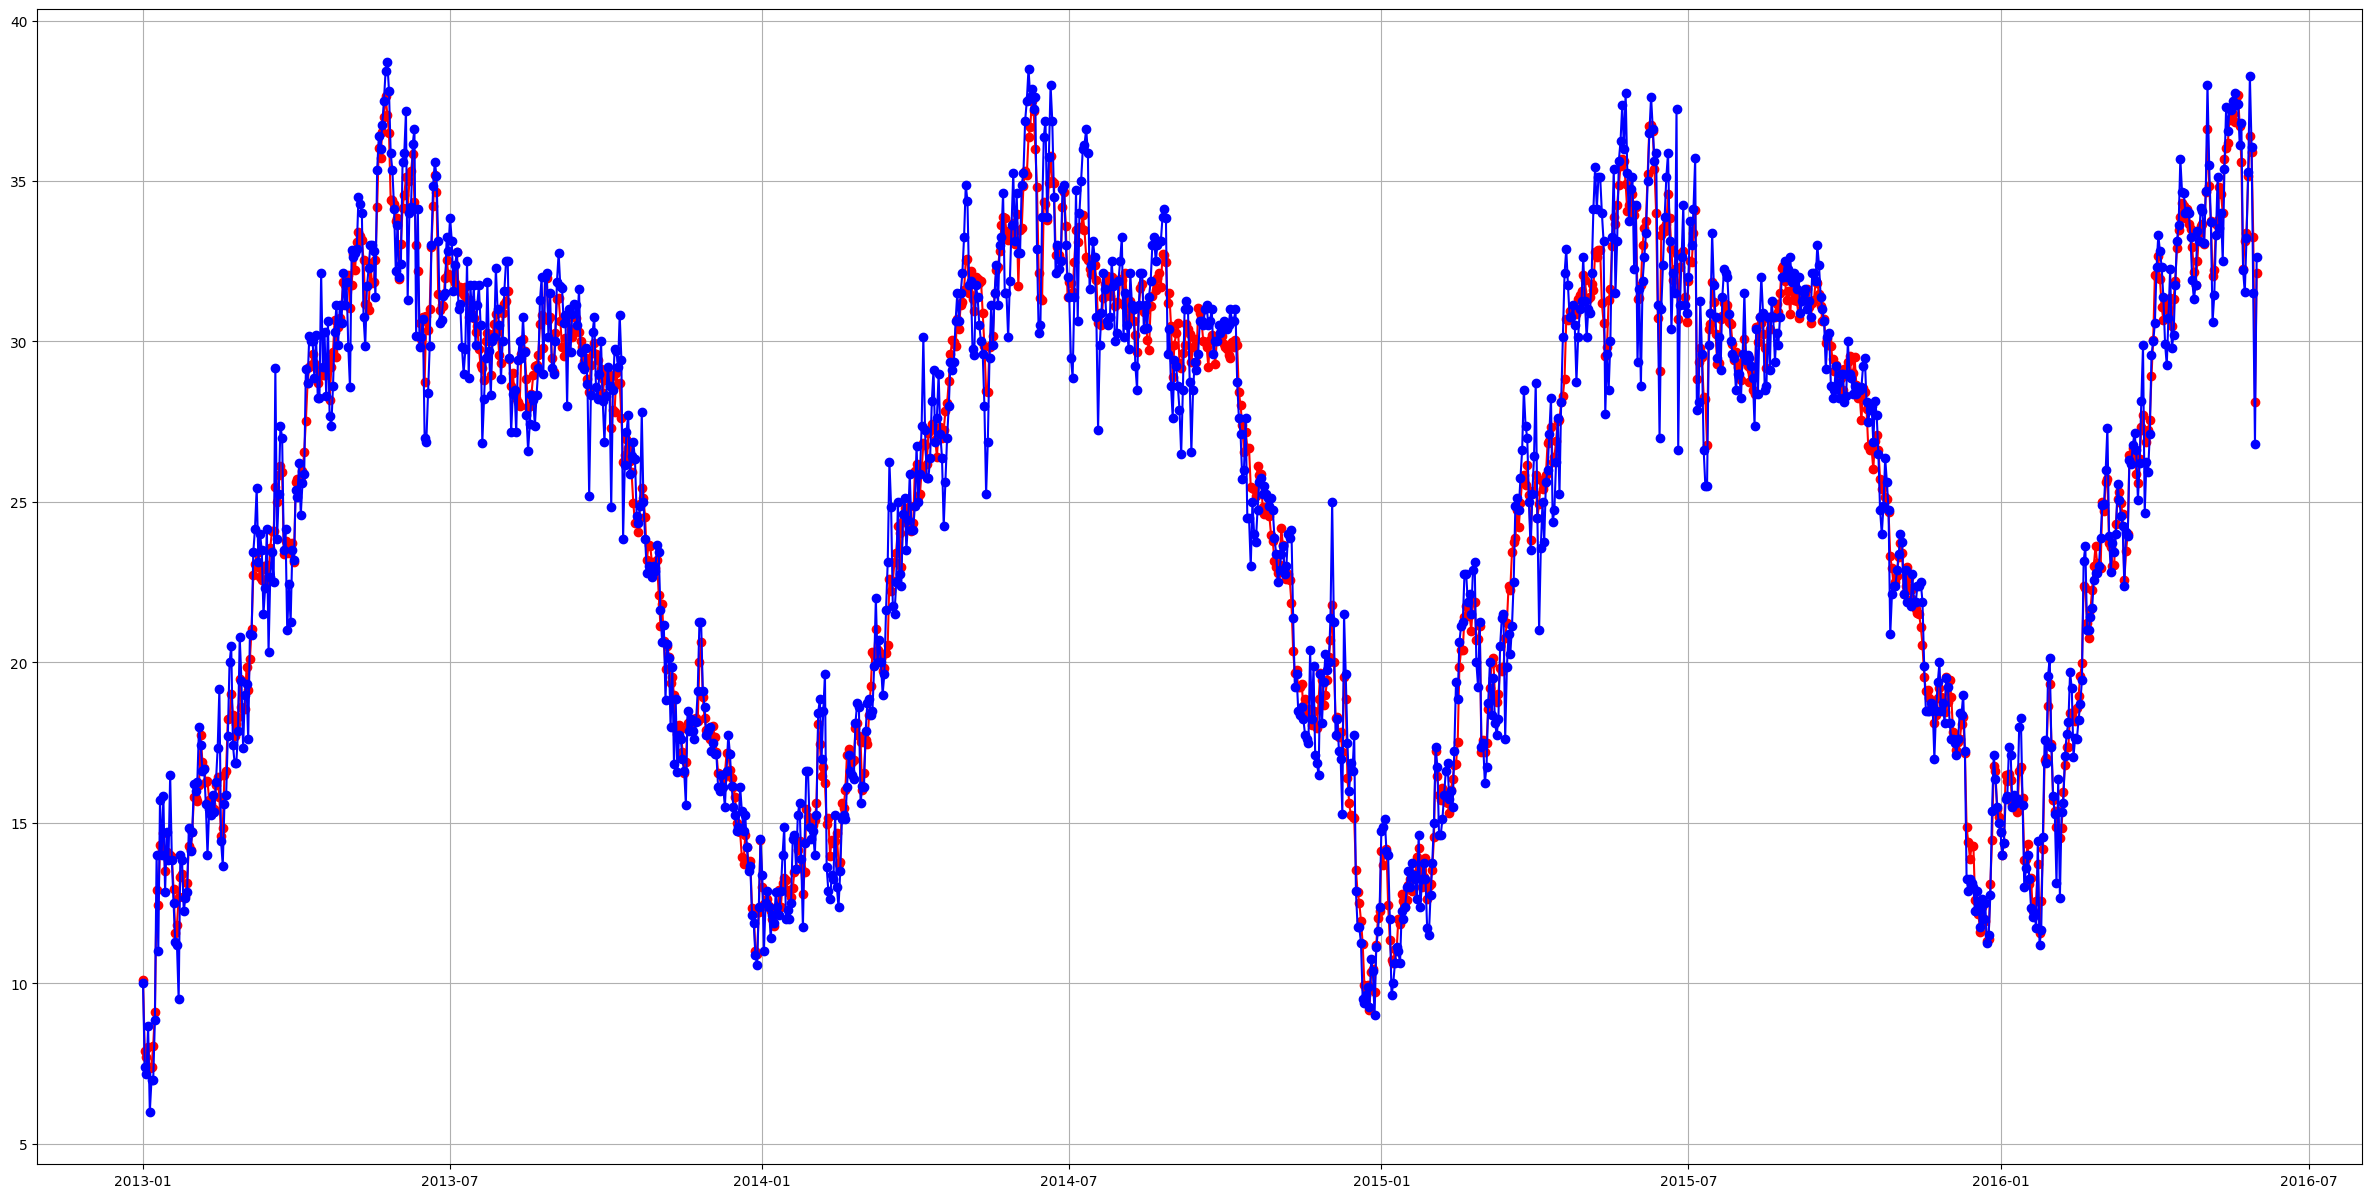

      year  weekofyear  quarter  month  dayofweek  day        Date  \
1247  2016          22        2      6          2    1    2016-6-1   
1248  2016          22        2      6          3    2    2016-6-2   
1249  2016          22        2      6          4    3    2016-6-3   
1250  2016          22        2      6          5    4    2016-6-4   
1251  2016          22        2      6          6    5    2016-6-5   
...    ...         ...      ...    ...        ...  ...         ...   
1457  2016          52        4     12          2   28  2016-12-28   
1458  2016          52        4     12          3   29  2016-12-29   
1459  2016          52        4     12          4   30  2016-12-30   
1460  2016          52        4     12          5   31  2016-12-31   
1461  2017          52        1      1          6    1    2017-1-1   

      predicted_target  actual_target  
1247         33.343071      36.000000  
1248         33.591137      37.562500  
1249         33.825035      37.562500  

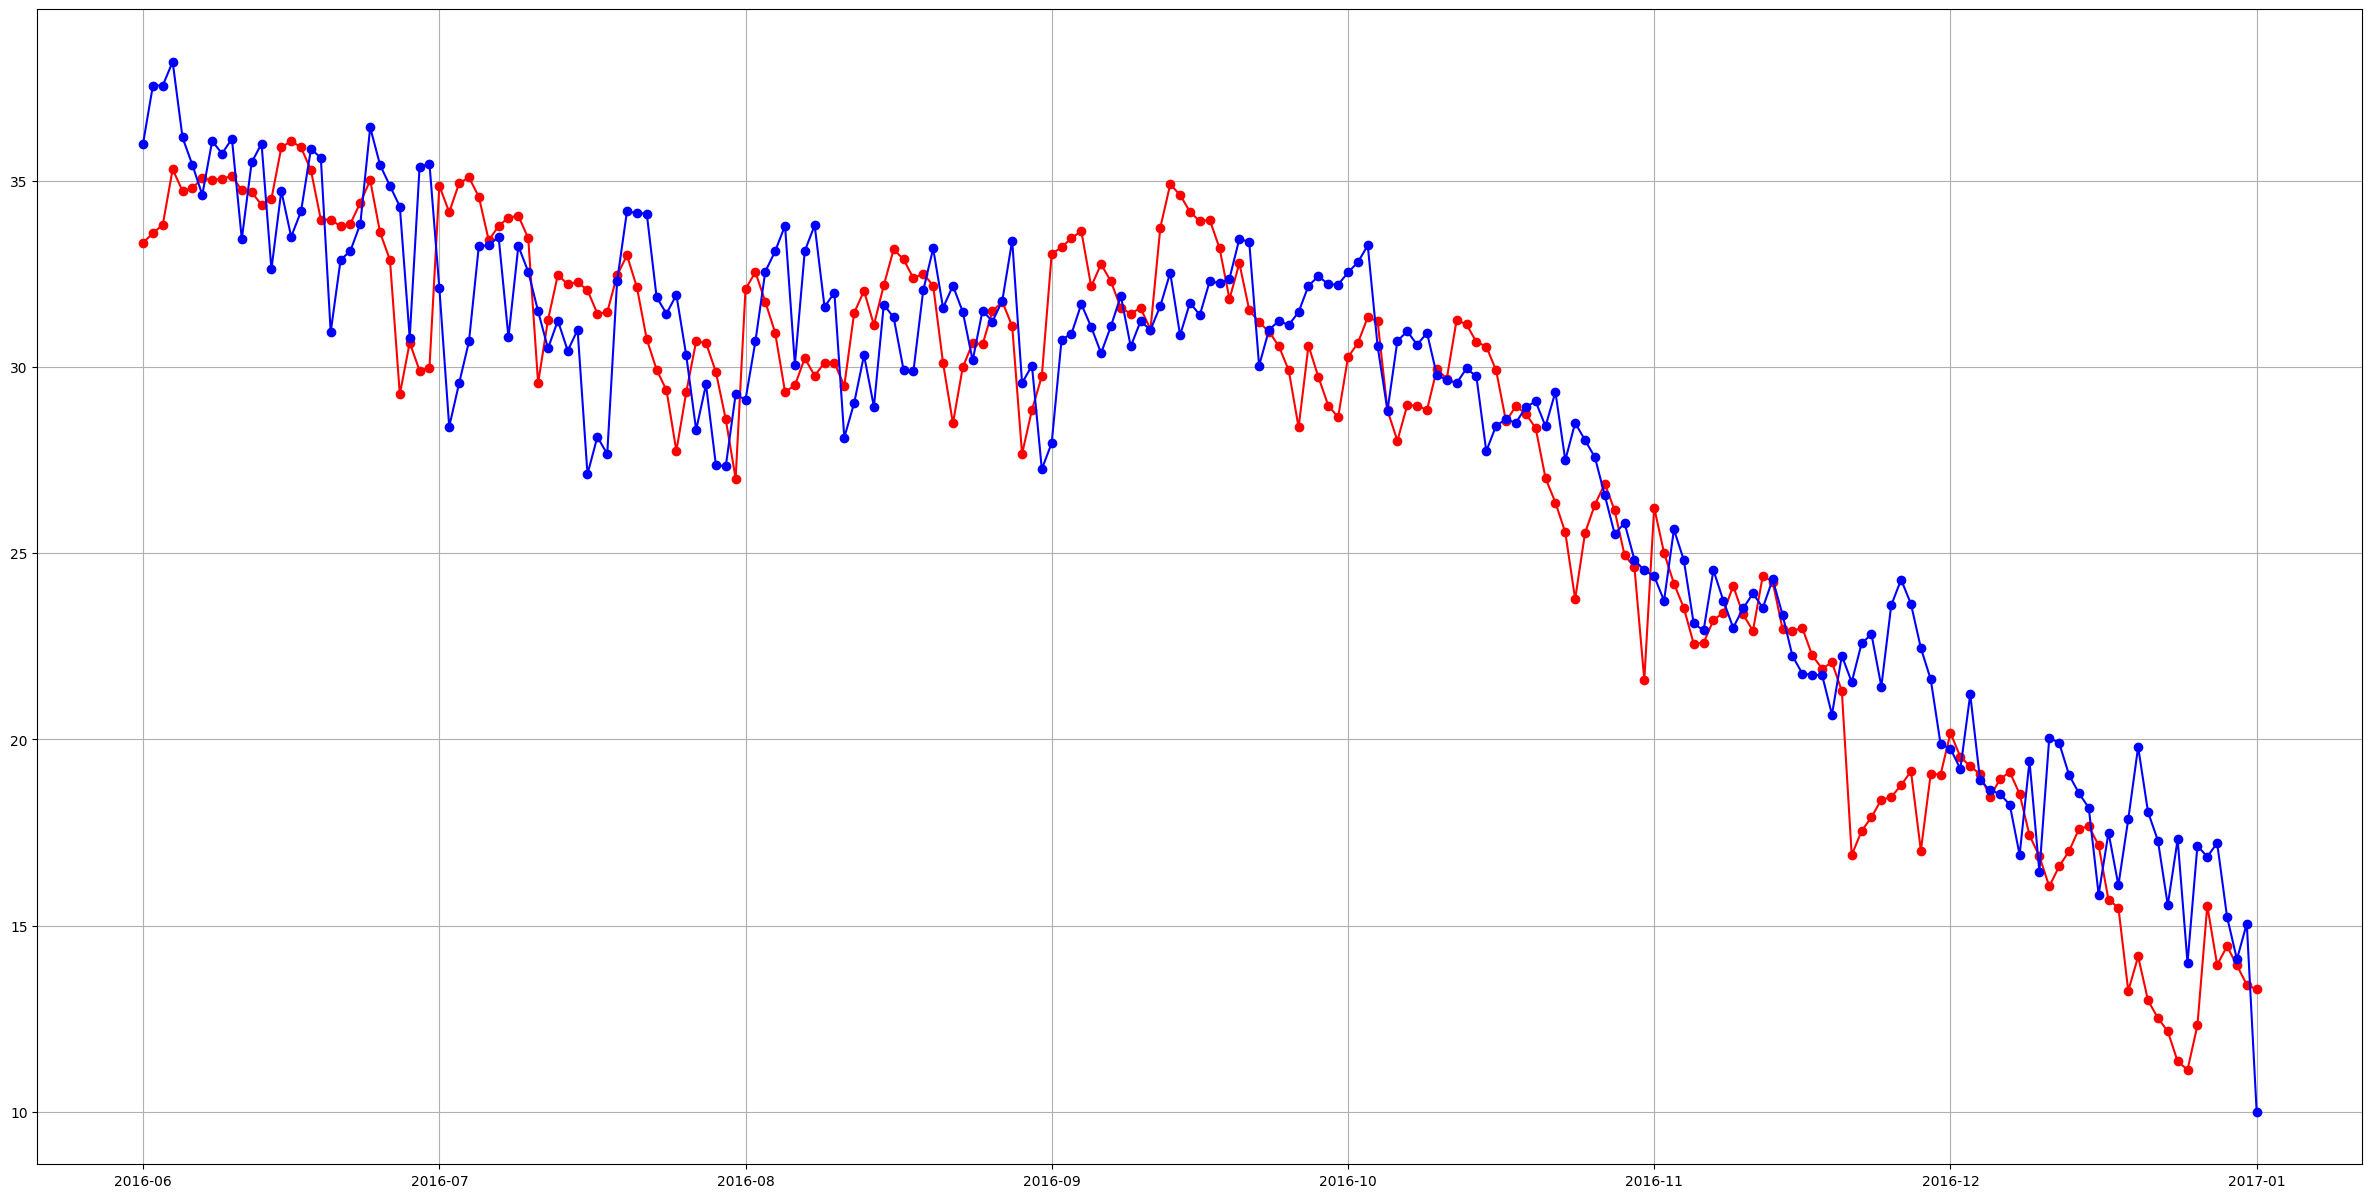

     year  weekofyear  quarter  month  dayofweek  day       Date  \
0    2017           1        1      1          0    2   2017-1-2   
1    2017           1        1      1          1    3   2017-1-3   
2    2017           1        1      1          2    4   2017-1-4   
3    2017           1        1      1          3    5   2017-1-5   
4    2017           1        1      1          4    6   2017-1-6   
..    ...         ...      ...    ...        ...  ...        ...   
175  2017          26        2      6          0   26  2017-6-26   
176  2017          26        2      6          1   27  2017-6-27   
177  2017          26        2      6          2   28  2017-6-28   
178  2017          26        2      6          3   29  2017-6-29   
179  2017          26        2      6          4   30  2017-6-30   

     predicted_target  actual_target  
0           17.018013              0  
1           16.120583              0  
2           16.192032              0  
3           15.888021      

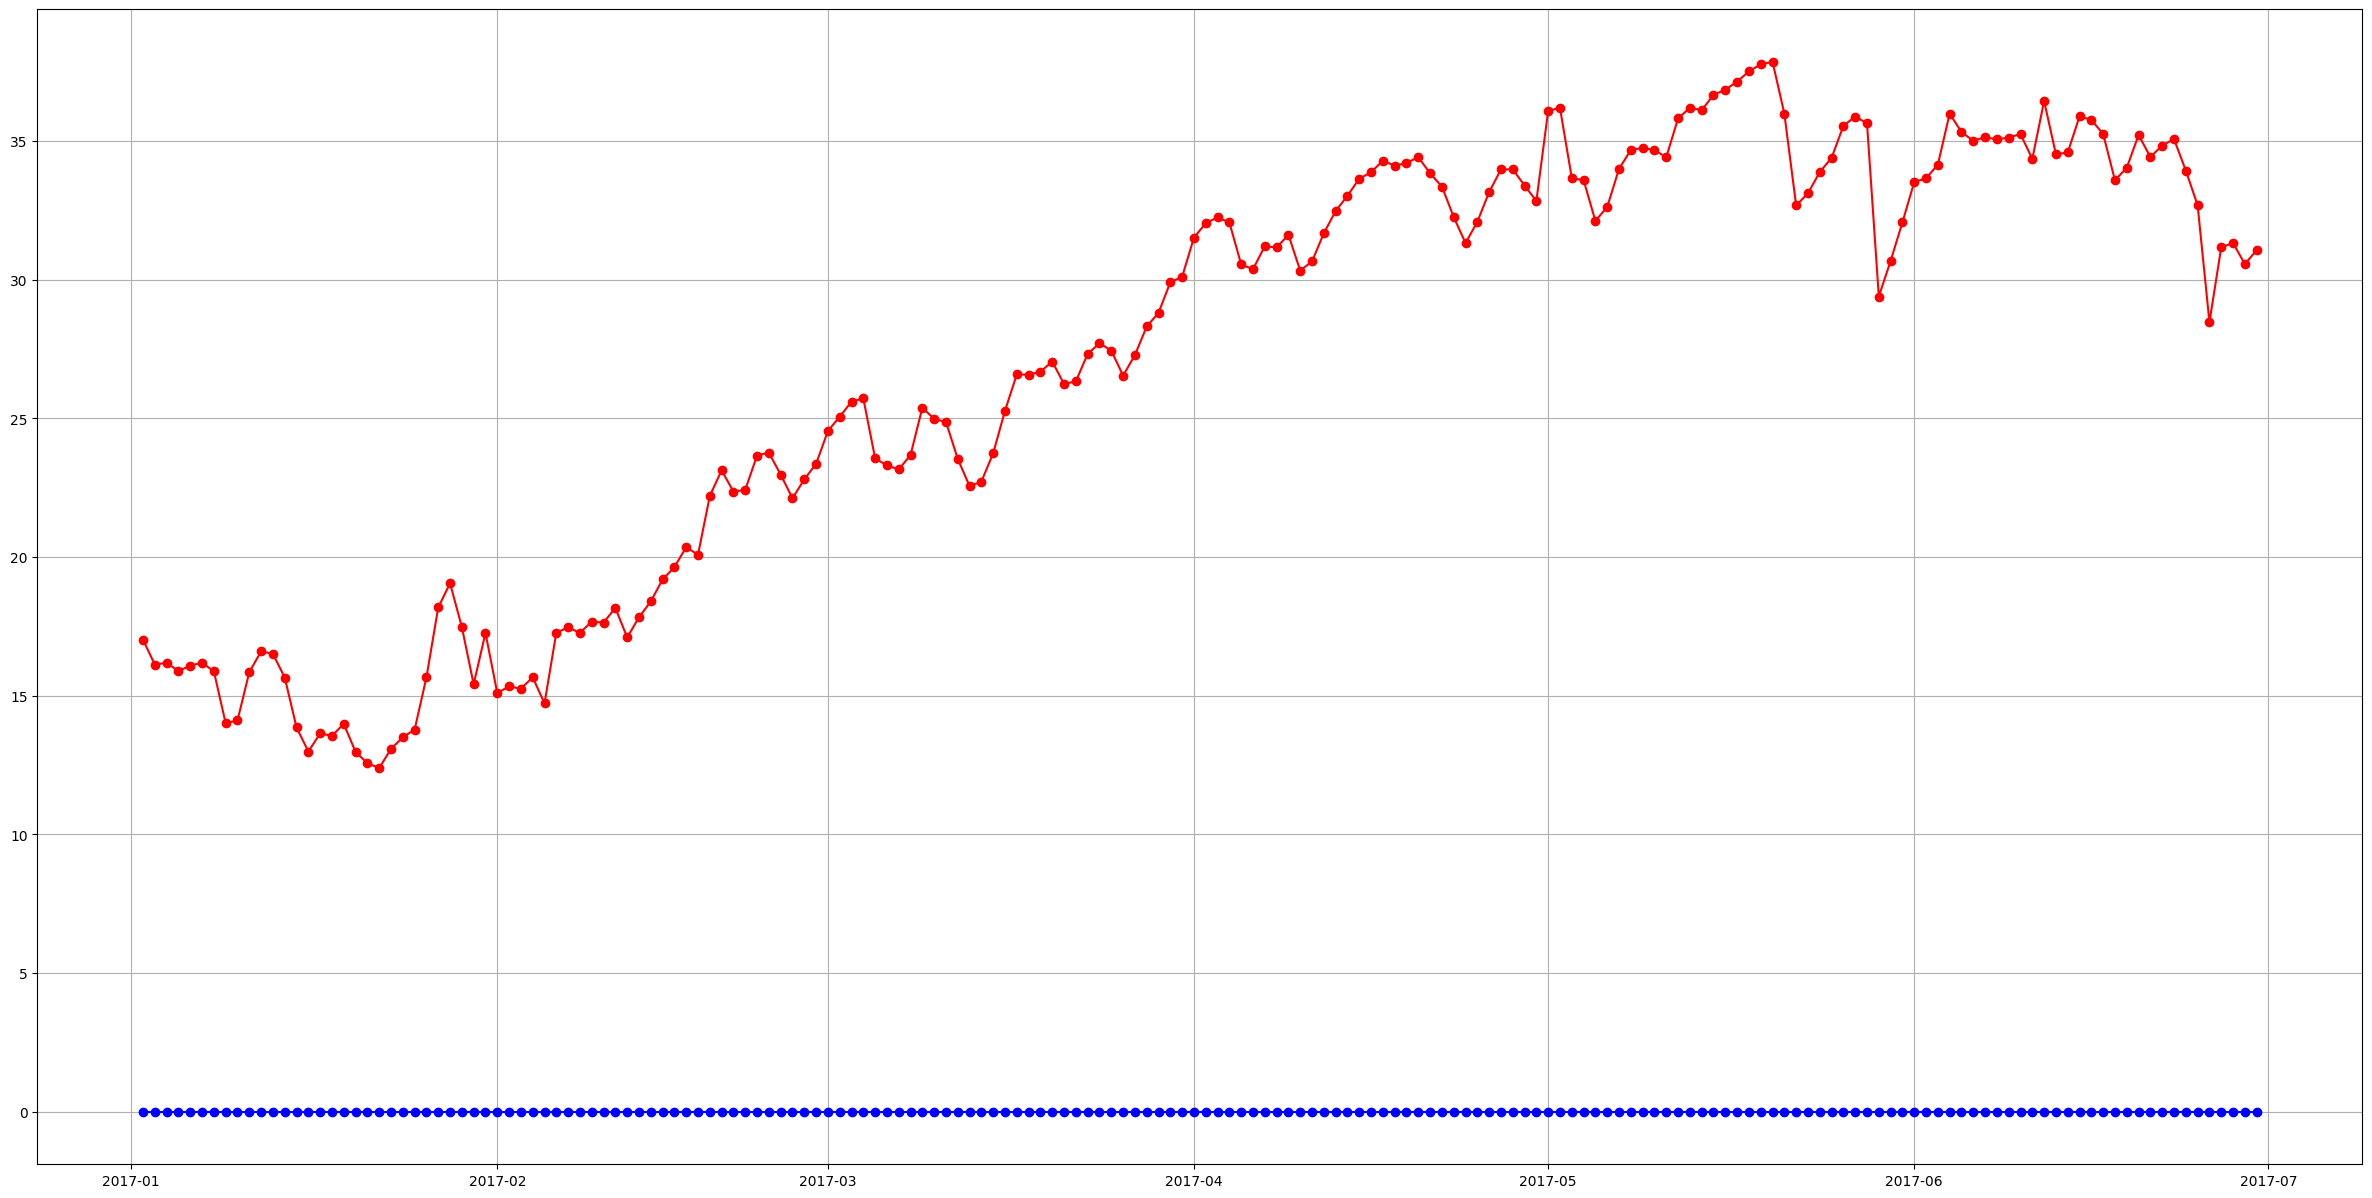

          Date      Value  id
0   2017-01-02  17.018013   8
1   2017-01-03  16.120583   8
2   2017-01-04  16.192032   8
3   2017-01-05  15.888021   8
4   2017-01-06  16.088213   8
..         ...        ...  ..
175 2017-06-26  28.466246   8
176 2017-06-27  31.169123   8
177 2017-06-28  31.322077   8
178 2017-06-29  30.564236   8
179 2017-06-30  31.066093   8

[180 rows x 3 columns]


In [14]:
for id, fileContent in idsWithPredictions.items():
    lags = [1, 2, 3, 6, 12, 24, 48, 96, 198]
    diffs = [1, 2, 3, 6, 12, 24, 48, 96, 198]
    param_grid = {
        'n_estimators': [100, 130, 160, 200],
        'max_depth': [4, 5, 6],
    }
    
    data = read_write_csv(fileContent, id, custom_date_parser)
    last_date_from_file = data['Date'].sort_values().iloc[-1]
    
    df_next_90_days = generate_next_90_days_dataframe(data, 'Date')
    
    # data = add_lagged_features(data, lags)
    # data = add_differenced_features(data, diffs)
    print(data.head())
    print("Dataframe next 90 days")
    print(df_next_90_days.head())
    print("Last date from file:")
    print(last_date_from_file)
    attr_train, attr_test, target_train, target_test = splitToTrainAndTest(data, '2016-06-01', last_date_from_file)
    
    attr_train = add_date_features(attr_train)
    attr_test = add_date_features(attr_test)
    real_prediction = add_date_features(df_next_90_days.drop(columns=['Value']))
    
    #Model searching for best params and training
    model = xgb.XGBRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
    grid_search.fit(attr_train, target_train)
    best_params = grid_search.best_params_
    print(best_params)
    model = xgb.XGBRegressor(**best_params)
    model.fit(attr_train, target_train)

    #Predicted result from train data
    predicted_train = np.clip(model.predict(attr_train), a_min=0, a_max=None)
    xgb.plot_importance(model)
    plotColumnsWithDetails(attr_train, target_train, predicted_train)
    
    #Prediction result from test data 
    predicted_test = np.clip(model.predict(attr_test), a_min=0, a_max=None)
    plotColumnsWithDetails(attr_test, target_test, predicted_test)
    
    #Prediction for the next 90 days
    predicted_test = np.clip(model.predict(real_prediction), a_min=0, a_max=None)
    plotColumnsWithDetails(real_prediction, df_next_90_days.get("Value"), predicted_test)
    predicted_test_for_database = pd.DataFrame({'Date': df_next_90_days['Date'], 'Value' : predicted_test})
    predicted_test_for_database['id'] = None
    predicted_test_for_database['id'] =  predicted_test_for_database['id'].fillna(id)
    print(predicted_test_for_database)
    with conn.cursor() as cur:
        sqlUpdateStatus = f"UPDATE prediction_request SET status = 'DONE' WHERE id = {id}"
        cur.execute(sqlUpdateStatus)
        for index, row in predicted_test_for_database.iterrows():
            sql = f"INSERT INTO prediction_response (id, request_id, date, value) VALUES (nextval('prediction_response_id_seq'), {row['id']}, DATE('{row['Date']}'), {row['Value']})"
            cur.execute(sql)
        cur.close()

In [15]:
conn.commit()
conn.close()
